In [1]:
import torch
import torch.nn as nn
from einops import rearrange
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils import data
import numpy as np
import pandas as pd
import os
import SimpleITK as sitk
import math

BATCH_SIZE=4
LR=0.05
DATA_PATH="./"
LOG_PATH="./log/hxd"
NUM_CLASS=4
BASE_CHAN=32
WEIGHT=[0.5,1,1,1]
WEIGHT_DECAY=0.0001
SCALE=0.3
ROTATE=180
CROP_SIZE=256
AUX_WEIGHT=[1,0.4,0.2,0.1]
REDUCE_SIZE=8
BLOCK_LIST="1234"
NUM_BLOCKS=[1,1,1,1]
GPU=0
DEVICE=torch.device("cpu")

In [2]:
class BasicBlock(nn.Module):

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        # 如果步长不为 1 或输入通道数不等于输出通道数，就会改变x尺寸以适应out尺寸
        if stride != 1 or inplanes != planes:
            self.shortcut = nn.Sequential(
                nn.BatchNorm2d(inplanes),
                self.relu,
                nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        residue = x

        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)

        out += self.shortcut(residue)

        return out

In [3]:
class depthwise_separable_conv(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1, kernel_size=3, padding=1, bias=False):
        super().__init__()
        # 这一行创建了一个深度卷积层 depthwise，其中 groups=in_ch 表示将输入通道分成多个组，每个组之间进行独立的卷积操作。这实现了深度可分离卷积的深度卷积部分。
        self.depthwise = nn.Conv2d(in_ch, in_ch, kernel_size=kernel_size, padding=padding, groups=in_ch, bias=bias,
                                   stride=stride)
        # 这一行创建了一个逐点卷积层 pointwise，用于将深度卷积的输出进行逐点卷积，实现特征的融合和映射。
        self.pointwise = nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=bias)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)

        return out

In [4]:
class RelativePositionBias(nn.Module):
    # input-independent relative position attention
    def __init__(self, num_heads, h, w):
        super().__init__()
        self.num_heads = num_heads
        self.h = h
        self.w = w

        # 创建相对位置偏置参数
        self.relative_position_bias_table = nn.Parameter(torch.randn((2 * h - 1) * (2 * w - 1), num_heads) * 0.02)  # (961,4)

        # 创建相对位置索引
        coords_h = torch.arange(self.h) # [16]
        coords_w = torch.arange(self.w)
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, h, w (2,16,16)
        coords_flatten = torch.flatten(coords, 1)  # 2, hw (2,256)

        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()
        relative_coords[:, :, 0] += self.h - 1
        relative_coords[:, :, 1] += self.w - 1
        relative_coords[:, :, 0] *= 2 * self.h - 1  # (256,256,2)
        relative_position_index = relative_coords.sum(-1)  # hw, hw (256,256)

        self.register_buffer("relative_position_index", relative_position_index)

    def forward(self, H, W):
        '''
        print(self.relative_position_index.view(-1).shape) --> [65536]
        self.relative_position_bias_table[self.relative_position_index.view(-1)] --> (65536,4)
        print(relative_position_bias.shape) --> torch.Size([16, 16, 256, 4])
        print(relative_position_bias_expand_h.shape) --> torch.Size([16, 16, 256, 4])
        print(relative_position_bias_expanded.shape) --> torch.Size([16, 16, 256, 4])
        print(relative_position_bias_expanded.shape) --> torch.Size([1, 4, 256, 256])
        '''
        # 计算相对位置偏置
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(self.h,self.w,self.h * self.w,-1)  # h, w, hw, nH   
        
        relative_position_bias_expand_h = torch.repeat_interleave(relative_position_bias, H // self.h, dim=0)

        relative_position_bias_expanded = torch.repeat_interleave(relative_position_bias_expand_h, W // self.w, dim=1)  # HW, hw, nH     
                                                              
        relative_position_bias_expanded = relative_position_bias_expanded.view(H * W, self.h * self.w,self.num_heads).permute(2, 0,1).contiguous().unsqueeze(0)
    
        return relative_position_bias_expanded

In [5]:
class LinearAttention(nn.Module):

    def __init__(self, dim, heads=4, dim_head=64, attn_drop=0., proj_drop=0., reduce_size=16, projection='interp',
                 rel_pos=True):
        super().__init__()

        self.inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** (-0.5)
        self.dim_head = dim_head
        self.reduce_size = reduce_size
        self.projection = projection
        self.rel_pos = rel_pos

        # 深度可分离卷积比1*1卷积效果好
        # self.to_qkv = nn.Conv2d(dim, self.inner_dim*3, kernel_size=1, stride=1, padding=0, bias=True)
        # self.to_out = nn.Conv2d(self.inner_dim, dim, kernel_size=1, stride=1, padding=0, bias=True)

        self.to_qkv = depthwise_separable_conv(dim, self.inner_dim * 3) # 输入特征图 x 经过深度可分离卷积得到查询（q）、键（k）和值（v）。
        self.to_out = depthwise_separable_conv(self.inner_dim, dim) # 经过注意力后的输出经过深度可分离卷积

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj_drop = nn.Dropout(proj_drop)

        if self.rel_pos:
            # 2D 输入无关的相对位置编码比 1D 输入相关的相对位置编码稍微更好一些
            self.relative_position_encoding = RelativePositionBias(heads, reduce_size, reduce_size)
            # self.relative_position_encoding = RelativePositionEmbedding(dim_head, reduce_size)

    def forward(self, x):

        B, C, H, W = x.shape

        # B, inner_dim, H, W
        qkv = self.to_qkv(x) # 将输入特征图 x 经过深度可分离卷积得到查询（q）、键（k）和值（v） 
        q, k, v = qkv.chunk(3, dim=1) # 将张量 qkv 按照维度 dim=1 进行分割，分成三个块，分别对应查询（q）、键（k）、值（v）。

        # 根据设定的投影方式，对键（k）和值（v）进行投影。
        ''' 
        inerp
        k 和 v:要进行插值的输入张量。
        size=self.reduce_size:目标尺寸，即要将张量调整到的大小。
        mode='bilinear'：插值模式，这里使用双线性插值。双线性插值是一种常用的插值方法，它可以平滑地对像素进行重新采样。
        align_corners=True: 用于控制插值是否对角点进行对齐。在图像处理中，通常设置为 True。
        这行代码的目的是将键k和值v的尺寸调整为指定的 self.reduce_size,以便在接下来的计算中使用。
        插值操作可以使得低分辨率的特征图在进行注意力计算时具有更大的感受野，从而提升模型的性能。 
        
        maxpool
        将键k和值v的尺寸调整为指定的 self.reduce_size,以便在接下来的计算中使用。
        自适应最大池化操作可以在保持重要信息的同时减少特征图的尺寸，从而降低计算负担并提高计算效率。
        '''
        if self.projection == 'interp' and H != self.reduce_size:
            k, v = map(lambda t: F.interpolate(t, size=self.reduce_size, mode='bilinear', align_corners=True), (k, v))

        elif self.projection == 'maxpool' and H != self.reduce_size:
            k, v = map(lambda t: F.adaptive_max_pool2d(t, output_size=self.reduce_size), (k, v))

        q = rearrange(q, 'b (dim_head heads) h w -> b heads (h w) dim_head', dim_head=self.dim_head, heads=self.heads,h=H, w=W)
        k, v = map(lambda t: rearrange(t, 'b (dim_head heads) h w -> b heads (h w) dim_head', dim_head=self.dim_head,
                                       heads=self.heads, h=self.reduce_size, w=self.reduce_size), (k, v))

        # 计算查询（q）与键（k）之间的注意力得分。
        q_k_attn = torch.einsum('bhid,bhjd->bhij', q, k) 

        # 如果启用了相对位置编码，将相对位置编码应用于注意力得分。
        if self.rel_pos:
            relative_position_bias = self.relative_position_encoding(H, W)
            q_k_attn += relative_position_bias  
            # rel_attn_h, rel_attn_w = self.relative_position_encoding(q, self.heads, H, W, self.dim_head)
            # q_k_attn = q_k_attn + rel_attn_h + rel_attn_w

        # 对注意力得分进行缩放并应用 dropout。
        q_k_attn *= self.scale 
        q_k_attn = F.softmax(q_k_attn, dim=-1)
        q_k_attn = self.attn_drop(q_k_attn)

        # # 对输出特征进行投影并应用 dropout。
        out = torch.einsum('bhij,bhjd->bhid', q_k_attn, v) 
        out = rearrange(out, 'b heads (h w) dim_head -> b (dim_head heads) h w', h=H, w=W, dim_head=self.dim_head,
                        heads=self.heads)

        out = self.to_out(out)
        out = self.proj_drop(out)

        return out, q_k_attn

In [6]:
class BasicTransBlock(nn.Module):

    def __init__(self, in_ch, heads, dim_head, attn_drop=0., proj_drop=0., reduce_size=16, projection='interp',
                 rel_pos=True):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(in_ch)

        self.attn = LinearAttention(in_ch, heads=heads, dim_head=in_ch // heads, attn_drop=attn_drop,
                                    proj_drop=proj_drop, reduce_size=reduce_size, projection=projection,
                                    rel_pos=rel_pos)

        self.bn2 = nn.BatchNorm2d(in_ch)
        self.relu = nn.ReLU(inplace=True)
        self.mlp = nn.Conv2d(in_ch, in_ch, kernel_size=1, bias=False)
        # conv1x1 has not difference with mlp in performance

    def forward(self, x):
        # 将输入数据 x 通过第一个 Batch Normalization 层。
        out = self.bn1(x)
        
        # 将输入数据传递给自注意力模块，得到自注意力的输出 out 和注意力矩阵 q_k_attn。
        out, q_k_attn = self.attn(out)

        # 对自注意力输出和输入进行残差连接，并将结果保存在 residue 中。
        out = out + x
        residue = out

        # 将 out 通过第二个 Batch Normalization 层。
        out = self.bn2(out)
        
        # 将 out 通过 ReLU 激活函数。
        out = self.relu(out)
        
        # 将 out 通过 1x1 卷积层（MLP）。
        out = self.mlp(out)

        # 将 residue 加到最终输出 out 上。
        out += residue

        return out

In [7]:
class down_block_trans(nn.Module):
    def __init__(self, in_ch, out_ch, num_block, bottleneck=False, maxpool=True, heads=4, dim_head=64, attn_drop=0.,
                 proj_drop=0., reduce_size=16, projection='interp', rel_pos=True):

        super().__init__()

        block_list = []

      
        block = BasicBlock

        attn_block = BasicTransBlock

        if maxpool:
            block_list.append(nn.MaxPool2d(2))
            block_list.append(block(in_ch, out_ch, stride=1))
        else:
            block_list.append(block(in_ch, out_ch, stride=2))

        assert num_block > 0
        for i in range(num_block):
            block_list.append(
                attn_block(out_ch, heads, dim_head, attn_drop=attn_drop, proj_drop=proj_drop, reduce_size=reduce_size,
                           projection=projection, rel_pos=rel_pos))
        self.blocks = nn.Sequential(*block_list)

    def forward(self, x):

        out = self.blocks(x)

        return out

In [8]:
class LinearAttentionDecoder(nn.Module):

    def __init__(self, in_dim, out_dim, heads=4, dim_head=64, attn_drop=0., proj_drop=0., reduce_size=16,
                 projection='interp', rel_pos=True):
        super().__init__()

        self.inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** (-0.5)
        self.dim_head = dim_head
        self.reduce_size = reduce_size
        self.projection = projection
        self.rel_pos = rel_pos

        # depthwise conv is slightly better than conv1x1
        # self.to_kv = nn.Conv2d(dim, self.inner_dim*2, kernel_size=1, stride=1, padding=0, bias=True)
        # self.to_q = nn.Conv2d(dim, self.inner_dim, kernel_size=1, stride=1, padding=0, bias=True)
        # self.to_out = nn.Conv2d(self.inner_dim, dim, kernel_size=1, stride=1, padding=0, bias=True)

        self.to_kv = depthwise_separable_conv(in_dim, self.inner_dim * 2)
        self.to_q = depthwise_separable_conv(out_dim, self.inner_dim)
        self.to_out = depthwise_separable_conv(self.inner_dim, out_dim)

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj_drop = nn.Dropout(proj_drop)

        if self.rel_pos:
            self.relative_position_encoding = RelativePositionBias(heads, reduce_size, reduce_size)
            # self.relative_position_encoding = RelativePositionEmbedding(dim_head, reduce_size)

    def forward(self, q, x):

        B, C, H, W = x.shape  # low-res feature shape
        BH, CH, HH, WH = q.shape  # high-res feature shape

        k, v = self.to_kv(x).chunk(2, dim=1)  # B, inner_dim, H, W
        q = self.to_q(q)  # BH, inner_dim, HH, WH

        # 使用键值投影层将输入特征图投影为键（k）和值（v）。
        if self.projection == 'interp' and H != self.reduce_size:
            k, v = map(lambda t: F.interpolate(t, size=self.reduce_size, mode='bilinear', align_corners=True), (k, v))

        elif self.projection == 'maxpool' and H != self.reduce_size:
            k, v = map(lambda t: F.adaptive_max_pool2d(t, output_size=self.reduce_size), (k, v))

        # 对查询（q）进行重排以适应多头自注意力计算的形状，并对键（k）和值（v）进行重排以适应相对位置编码的形状。
        q = rearrange(q, 'b (dim_head heads) h w -> b heads (h w) dim_head', dim_head=self.dim_head, heads=self.heads,
                      h=HH, w=WH)
        k, v = map(lambda t: rearrange(t, 'b (dim_head heads) h w -> b heads (h w) dim_head', dim_head=self.dim_head,
                                       heads=self.heads, h=self.reduce_size, w=self.reduce_size), (k, v))

        # 使用torch.einsum计算查询-键（q-k）注意力权重矩阵。
        q_k_attn = torch.einsum('bhid,bhjd->bhij', q, k)

        # 如果启用相对位置编码，将相对位置偏置加到注意力权重矩阵中。
        if self.rel_pos:
            relative_position_bias = self.relative_position_encoding(HH, WH)
            q_k_attn += relative_position_bias
            # rel_attn_h, rel_attn_w = self.relative_position_encoding(q, self.heads, HH, WH, self.dim_head)
            # q_k_attn = q_k_attn + rel_attn_h + rel_attn_w

        # 对注意力权重进行缩放,将缩放后的注意力权重进行softmax操作，然后应用注意力丢弃（attn_drop）
        q_k_attn *= self.scale
        q_k_attn = F.softmax(q_k_attn, dim=-1)
        q_k_attn = self.attn_drop(q_k_attn)

        # 使用torch.einsum将注意力权重和值（v）进行加权求和，计算出上下文向量。
        out = torch.einsum('bhij,bhjd->bhid', q_k_attn, v)
        
        # 将上下文向量重新排列以适应输出的形状，并应用输出投影层，将其投影到指定的输出特征维度。
        out = rearrange(out, 'b heads (h w) dim_head -> b (dim_head heads) h w', h=HH, w=WH, dim_head=self.dim_head,
                        heads=self.heads)
        out = self.to_out(out)
        
        # 最后，对输出应用投影丢弃（proj_drop）
        out = self.proj_drop(out)

        return out, q_k_attn

In [9]:
class BasicTransDecoderBlock(nn.Module):

    def __init__(self, in_ch, out_ch, heads, dim_head, attn_drop=0., proj_drop=0., reduce_size=16, projection='interp',
                 rel_pos=True):
        super().__init__()

        self.bn_l = nn.BatchNorm2d(in_ch)
        self.bn_h = nn.BatchNorm2d(out_ch)

        self.conv_ch = nn.Conv2d(in_ch, out_ch, kernel_size=1)
        self.attn = LinearAttentionDecoder(in_ch, out_ch, heads=heads, dim_head=out_ch // heads, attn_drop=attn_drop,
                                           proj_drop=proj_drop, reduce_size=reduce_size, projection=projection,
                                           rel_pos=rel_pos)

        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        self.mlp = nn.Conv2d(out_ch, out_ch, kernel_size=1, bias=False)

    def forward(self, x1, x2):
        # 使用self.conv_ch对低分辨率特征图x1进行卷积，然后使用插值（F.interpolate）将其大小调整为高分辨率特征图x2的大小，得到residue。
        residue = F.interpolate(self.conv_ch(x1), size=x2.shape[-2:], mode='bilinear', align_corners=True)
        
        # x1: low-res, x2: high-res,对输入的低分辨率特征图x1和高分辨率特征图x2分别进行批量归一化。
        x1 = self.bn_l(x1)
        x2 = self.bn_h(x2)

        # 使用self.attn模块对高分辨率特征图x2和低分辨率特征图x1进行解码，得到解码后的特征图out和注意力权重q_k_attn。
        out, q_k_attn = self.attn(x2, x1)

        # 将out和residue相加，得到out。(残差)
        out = out + residue
        residue = out

        # 对解码后的特征图out进行批量归一化。使用ReLU激活函数对out进行激活。使用self.mlp对out进行卷积操作，得到最终的解码结果。
        out = self.bn2(out)
        out = self.relu(out)
        out = self.mlp(out)

        out += residue

        return out

In [10]:
class up_block_trans(nn.Module):
    def __init__(self, in_ch, out_ch, num_block, bottleneck=False, heads=4, dim_head=64, attn_drop=0., proj_drop=0.,
                 reduce_size=16, projection='interp', rel_pos=True):
        super().__init__()

        self.attn_decoder = BasicTransDecoderBlock(in_ch, out_ch, heads=heads, dim_head=dim_head, attn_drop=attn_drop,
                                                   proj_drop=proj_drop, reduce_size=reduce_size, projection=projection,
                                                   rel_pos=rel_pos)

        block = BasicBlock
        attn_block = BasicTransBlock

        block_list = []

        for i in range(num_block):
            block_list.append(
                attn_block(out_ch, heads, dim_head, attn_drop=attn_drop, proj_drop=proj_drop, reduce_size=reduce_size,
                           projection=projection, rel_pos=rel_pos))

        block_list.append(block(2 * out_ch, out_ch, stride=1))

        self.blocks = nn.Sequential(*block_list)

    def forward(self, x1, x2):
        # x1: low-res feature, x2: high-res feature
        # 使用self.attn_decoder对输入的低分辨率特征图x1和高分辨率特征图x2进行解码和上采样，得到解码后的特征图out。
        out = self.attn_decoder(x1, x2)
        
        # 将解码后的特征图out和高分辨率特征图x2在通道维度上拼接起来，形成一个更丰富的特征图。
        out = torch.cat([out, x2], dim=1)
        
        # 使用一系列attn_block模块对拼接后的特征图进行注意力计算和解码。(残差模块)
        out = self.blocks(out)

        return out

In [11]:
class down_block(nn.Module):
    def __init__(self, in_ch, out_ch, scale, num_block, bottleneck=False, pool=True):
        super().__init__()

        block_list = []

        block = BasicBlock

        if pool:
            block_list.append(nn.MaxPool2d(scale))
            block_list.append(block(in_ch, out_ch))
        else:
            block_list.append(block(in_ch, out_ch, stride=2))

        for i in range(num_block - 1):
            block_list.append(block(out_ch, out_ch, stride=1))

        self.conv = nn.Sequential(*block_list)

    def forward(self, x):
        return self.conv(x)


class up_block(nn.Module):
    def __init__(self, in_ch, out_ch, num_block, scale=(2, 2), bottleneck=False):
        super().__init__()
        self.scale = scale

        self.conv_ch = nn.Conv2d(in_ch, out_ch, kernel_size=1)

        block = BasicBlock

        block_list = []
        block_list.append(block(2 * out_ch, out_ch))

        for i in range(num_block - 1):
            block_list.append(block(out_ch, out_ch))

        self.conv = nn.Sequential(*block_list)

    def forward(self, x1, x2):
        x1 = F.interpolate(x1, scale_factor=self.scale, mode='bilinear', align_corners=True)
        x1 = self.conv_ch(x1)

        out = torch.cat([x2, x1], dim=1)
        out = self.conv(out)

        return out

In [12]:
class UTNet(nn.Module):

    def __init__(self, in_chan, base_chan, num_classes=1, reduce_size=8, block_list='234', num_blocks=[1, 2, 4],
                 projection='interp', num_heads=[2, 4, 8], attn_drop=0., proj_drop=0., bottleneck=False, maxpool=True,
                 rel_pos=True, aux_loss=False):
        super().__init__()

        self.aux_loss = aux_loss
        self.inc = [BasicBlock(in_chan, base_chan)]
        if '0' in block_list:
            self.inc.append(BasicTransBlock(base_chan, heads=num_heads[-5], dim_head=base_chan // num_heads[-5],
                                            attn_drop=attn_drop, proj_drop=proj_drop, reduce_size=reduce_size,
                                            projection=projection, rel_pos=rel_pos))
            self.up4 = up_block_trans(2 * base_chan, base_chan, num_block=0, bottleneck=bottleneck, heads=num_heads[-4],
                                      dim_head=base_chan // num_heads[-4], attn_drop=attn_drop, proj_drop=proj_drop,
                                      reduce_size=reduce_size, projection=projection, rel_pos=rel_pos)

        else:
            self.inc.append(BasicBlock(base_chan, base_chan))
            self.up4 = up_block(2 * base_chan, base_chan, scale=(2, 2), num_block=2)
        self.inc = nn.Sequential(*self.inc)

        if '1' in block_list:
            self.down1 = down_block_trans(base_chan, 2 * base_chan, num_block=num_blocks[-4], bottleneck=bottleneck,
                                          maxpool=maxpool, heads=num_heads[-4], dim_head=2 * base_chan // num_heads[-4],
                                          attn_drop=attn_drop, proj_drop=proj_drop, reduce_size=reduce_size,
                                          projection=projection, rel_pos=rel_pos)
            self.up3 = up_block_trans(4 * base_chan, 2 * base_chan, num_block=0, bottleneck=bottleneck,
                                      heads=num_heads[-3], dim_head=2 * base_chan // num_heads[-3], attn_drop=attn_drop,
                                      proj_drop=proj_drop, reduce_size=reduce_size, projection=projection,
                                      rel_pos=rel_pos)
        else:
            self.down1 = down_block(base_chan, 2 * base_chan, (2, 2), num_block=2)
            self.up3 = up_block(4 * base_chan, 2 * base_chan, scale=(2, 2), num_block=2)

        if '2' in block_list:
            self.down2 = down_block_trans(2 * base_chan, 4 * base_chan, num_block=num_blocks[-3], bottleneck=bottleneck,
                                          maxpool=maxpool, heads=num_heads[-3], dim_head=4 * base_chan // num_heads[-3],
                                          attn_drop=attn_drop, proj_drop=proj_drop, reduce_size=reduce_size,
                                          projection=projection, rel_pos=rel_pos)
            self.up2 = up_block_trans(8 * base_chan, 4 * base_chan, num_block=0, bottleneck=bottleneck,
                                      heads=num_heads[-2], dim_head=4 * base_chan // num_heads[-2], attn_drop=attn_drop,
                                      proj_drop=proj_drop, reduce_size=reduce_size, projection=projection,
                                      rel_pos=rel_pos)

        else:
            self.down2 = down_block(2 * base_chan, 4 * base_chan, (2, 2), num_block=2)
            self.up2 = up_block(8 * base_chan, 4 * base_chan, scale=(2, 2), num_block=2)

        if '3' in block_list:
            self.down3 = down_block_trans(4 * base_chan, 8 * base_chan, num_block=num_blocks[-2], bottleneck=bottleneck,
                                          maxpool=maxpool, heads=num_heads[-2], dim_head=8 * base_chan // num_heads[-2],
                                          attn_drop=attn_drop, proj_drop=proj_drop, reduce_size=reduce_size,
                                          projection=projection, rel_pos=rel_pos)
            self.up1 = up_block_trans(16 * base_chan, 8 * base_chan, num_block=0, bottleneck=bottleneck,
                                      heads=num_heads[-1], dim_head=8 * base_chan // num_heads[-1], attn_drop=attn_drop,
                                      proj_drop=proj_drop, reduce_size=reduce_size, projection=projection,
                                      rel_pos=rel_pos)

        else:
            self.down3 = down_block(4 * base_chan, 8 * base_chan, (2, 2), num_block=2)
            self.up1 = up_block(16 * base_chan, 8 * base_chan, scale=(2, 2), num_block=2)

        if '4' in block_list:
            self.down4 = down_block_trans(8 * base_chan, 16 * base_chan, num_block=num_blocks[-1],
                                          bottleneck=bottleneck, maxpool=maxpool, heads=num_heads[-1],
                                          dim_head=16 * base_chan // num_heads[-1], attn_drop=attn_drop,
                                          proj_drop=proj_drop, reduce_size=reduce_size, projection=projection,
                                          rel_pos=rel_pos)
        else:
            self.down4 = down_block(8 * base_chan, 16 * base_chan, (2, 2), num_block=2)

        self.outc = nn.Conv2d(base_chan, num_classes, kernel_size=1, bias=True)

        if aux_loss:
            self.out1 = nn.Conv2d(8 * base_chan, num_classes, kernel_size=1, bias=True)
            self.out2 = nn.Conv2d(4 * base_chan, num_classes, kernel_size=1, bias=True)
            self.out3 = nn.Conv2d(2 * base_chan, num_classes, kernel_size=1, bias=True)

    def forward(self, x):

        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        if self.aux_loss:
            out = self.up1(x5, x4)
            out1 = F.interpolate(self.out1(out), size=x.shape[-2:], mode='bilinear', align_corners=True)

            out = self.up2(out, x3)
            out2 = F.interpolate(self.out2(out), size=x.shape[-2:], mode='bilinear', align_corners=True)

            out = self.up3(out, x2)
            out3 = F.interpolate(self.out3(out), size=x.shape[-2:], mode='bilinear', align_corners=True)

            out = self.up4(out, x1)
            out = self.outc(out)

            return out, out3, out2, out1

        else:
            out = self.up1(x5, x4)
            out = self.up2(out, x3)
            out = self.up3(out, x2)

            out = self.up4(out, x1)
            out = self.outc(out)

            return out

In [13]:
utnet = UTNet(1, BASE_CHAN, NUM_CLASS, reduce_size=REDUCE_SIZE,
                    block_list=BLOCK_LIST, num_blocks=NUM_BLOCKS, num_heads=[4, 4, 4, 4],
                    projection='interp', attn_drop=0.1, proj_drop=0.1, rel_pos=True, aux_loss=True,
                    maxpool=True).to(DEVICE)
param_num = sum(p.numel() for p in utnet.parameters() if p.requires_grad)

print("The structure of UTNet:\n",utnet)
print("The para_num of UTNet: ",param_num)

The structure of UTNet:
 UTNet(
  (up4): up_block(
    (conv_ch): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (conv): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU(inplace=True)
          (2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
      )
      (1): BasicBlock(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, moment

d:\Anacona\envs\hxd\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [14]:
class CMRDataset(Dataset):
    def __init__(self, dataset_dir, mode='train', domain='A', crop_size=256, scale=0.1, rotate=10, debug=False):

        self.mode = mode
        self.dataset_dir = dataset_dir
        self.crop_size = crop_size
        self.scale = scale
        self.rotate = rotate

        if self.mode == 'train':
            pre_face = 'Training'
            if 'C' in domain or 'D' in domain:
                print('No domain C or D in Training set')
                raise BaseException

        elif self.mode == 'test':
            pre_face = 'Testing'

        else:
            print('Wrong mode')
            raise BaseException
        if debug:
            pre_face = 'Testing'

        path = self.dataset_dir + pre_face + '/'
        print('start loading data')

        name_list = []

        if 'A' in domain:
            df = pd.read_csv(self.dataset_dir + pre_face + '_A.csv')
            name_list += np.array(df['name']).tolist()
        if 'B' in domain:
            df = pd.read_csv(self.dataset_dir + pre_face + '_B.csv')
            name_list += np.array(df['name']).tolist()
        if 'C' in domain:
            df = pd.read_csv(self.dataset_dir + pre_face + '_C.csv')
            name_list += np.array(df['name']).tolist()
        if 'D' in domain:
            df = pd.read_csv(self.dataset_dir + pre_face + '_D.csv')
            name_list += np.array(df['name']).tolist()

        img_list = []
        lab_list = []
        spacing_list = []

        for name in name_list:
            for name_idx in os.listdir(path + name):
                if 'gt' in name_idx:
                    continue
                else:
                    idx = name_idx.split('_')[2].split('.')[0]

                    itk_img = sitk.ReadImage(path + name + '/%s_sa_%s.nii.gz' % (name, idx))
                    itk_lab = sitk.ReadImage(path + name + '/%s_sa_gt_%s.nii.gz' % (name, idx))

                    spacing = np.array(itk_lab.GetSpacing()).tolist()
                    spacing_list.append(spacing[::-1])

                    assert itk_img.GetSize() == itk_lab.GetSize()
                    img, lab = self.preprocess(itk_img, itk_lab)

                    img_list.append(img)
                    lab_list.append(lab)

        self.img_slice_list = []
        self.lab_slice_list = []
        if self.mode == 'train':
            for i in range(len(img_list)):
                tmp_img = img_list[i]
                tmp_lab = lab_list[i]

                z, x, y = tmp_img.shape

                for j in range(z):
                    self.img_slice_list.append(tmp_img[j])
                    self.lab_slice_list.append(tmp_lab[j])

        else:
            self.img_slice_list = img_list
            self.lab_slice_list = lab_list
            self.spacing_list = spacing_list

        print('load done, length of dataset:', len(self.img_slice_list))
        # print("train data size:",self.img_slice_list[0].shape) # [283,265]
        # print("test data size:",self.img_slice_list[0].shape) # [12,317,317]
        # print("spacing size:",self.spacing_list[0]) # [3]

    def __len__(self):
        return len(self.img_slice_list)

    def preprocess(self, itk_img, itk_lab):

        img = sitk.GetArrayFromImage(itk_img)
        lab = sitk.GetArrayFromImage(itk_lab)

        max98 = np.percentile(img, 98)
        img = np.clip(img, 0, max98)

        z, y, x = img.shape
        if x < self.crop_size:
            diff = (self.crop_size + 10 - x) // 2
            img = np.pad(img, ((0, 0), (0, 0), (diff, diff)))
            lab = np.pad(lab, ((0, 0), (0, 0), (diff, diff)))
        if y < self.crop_size:
            diff = (self.crop_size + 10 - y) // 2
            img = np.pad(img, ((0, 0), (diff, diff), (0, 0)))
            lab = np.pad(lab, ((0, 0), (diff, diff), (0, 0)))

        img = img / max98
        tensor_img = torch.from_numpy(img).float()
        tensor_lab = torch.from_numpy(lab).long()

        return tensor_img, tensor_lab

    def __getitem__(self, idx):
        tensor_image = self.img_slice_list[idx]
        tensor_label = self.lab_slice_list[idx]

        if self.mode == 'train':
            # unsqueeze(0).unsqueeze(0)：在第一个和第二个维度上添加一个维度，将图像和标签的形状从 [H, W] 扩展为 [1, 1, H, W]。这是为了将单个通道的图像和标签匹配到一个通道上。
            tensor_image = tensor_image.unsqueeze(0).unsqueeze(0)
            tensor_label = tensor_label.unsqueeze(0).unsqueeze(0)

            # Gaussian Noise 高斯噪声：给图像张量添加服从均值为0、标准差为0.02的高斯噪声，以增加数据的多样性。
            tensor_image += torch.randn(tensor_image.shape) * 0.02
            
            # Additive brightness 亮度调整：随机添加一个服从均值为0、标准差为0.7的正态分布随机数到图像张量，以进行亮度的随机调整。
            rnd_bn = np.random.normal(0, 0.7)  # 0.03
            tensor_image += rnd_bn
            
            # gamma Gamma 校正：对图像张量进行 Gamma 校正，以改变图像的对比度。
            minm = tensor_image.min()
            rng = tensor_image.max() - minm
            gamma = np.random.uniform(0.5, 1.6)
            tensor_image = torch.pow((tensor_image - minm) / rng, gamma) * rng + minm

            # 对图像和标签进行随机缩放和旋转操作，增加样本的多样性。
            tensor_image, tensor_label = self.random_zoom_rotate(tensor_image, tensor_label)
            
            # 对图像和标签进行随机缩放和旋转操作，增加样本的多样性。
            tensor_image, tensor_label = self.randcrop(tensor_image, tensor_label)
        else:
            # 在非训练模式下（其他模式），只执行了 center_crop 操作，将图像和标签进行中心裁剪。
            tensor_image, tensor_label = self.center_crop(tensor_image, tensor_label)

        assert tensor_image.shape == tensor_label.shape

        if self.mode == 'train':
            return tensor_image, tensor_label
        else:
            return tensor_image, tensor_label, np.array(self.spacing_list[idx])

    def randcrop(self, img, label):
        _, _, H, W = img.shape

        diff_H = H - self.crop_size
        diff_W = W - self.crop_size

        rand_x = np.random.randint(0, diff_H)
        rand_y = np.random.randint(0, diff_W)

        croped_img = img[0, :, rand_x:rand_x + self.crop_size, rand_y:rand_y + self.crop_size]
        croped_lab = label[0, :, rand_x:rand_x + self.crop_size, rand_y:rand_y + self.crop_size]

        return croped_img, croped_lab

    def center_crop(self, img, label):
        D, H, W = img.shape

        diff_H = H - self.crop_size
        diff_W = W - self.crop_size

        rand_x = diff_H // 2
        rand_y = diff_W // 2

        croped_img = img[:, rand_x:rand_x + self.crop_size, rand_y:rand_y + self.crop_size]
        croped_lab = label[:, rand_x:rand_x + self.crop_size, rand_y:rand_y + self.crop_size]

        return croped_img, croped_lab

    def random_zoom_rotate(self, img, label):
        scale_x = np.random.random() * 2 * self.scale + (1 - self.scale)
        scale_y = np.random.random() * 2 * self.scale + (1 - self.scale)

        theta_scale = torch.tensor([[scale_x, 0, 0],
                                    [0, scale_y, 0],
                                    [0, 0, 1]]).float()
        angle = (float(np.random.randint(-self.rotate, self.rotate)) / 180.) * math.pi

        theta_rotate = torch.tensor([[math.cos(angle), -math.sin(angle), 0],
                                     [math.sin(angle), math.cos(angle), 0],
                                     ]).float()

        theta_rotate = theta_rotate.unsqueeze(0)
        grid = F.affine_grid(theta_rotate, img.size())
        img = F.grid_sample(img, grid, mode='bilinear')
        label = F.grid_sample(label.float(), grid, mode='nearest').long()

        return img, label
    
    

In [15]:
trainset = CMRDataset(DATA_PATH, mode='train', domain="AB", debug=False, scale=SCALE,
                          rotate=ROTATE, crop_size=CROP_SIZE)
trainLoader = data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testset_C = CMRDataset(DATA_PATH, mode='test', domain='C', debug=False, crop_size=CROP_SIZE)
testLoader_C = data.DataLoader(testset_C, batch_size=1, shuffle=False, num_workers=0)
testset_D = CMRDataset(DATA_PATH, mode='test', domain='D', debug=False, crop_size=CROP_SIZE)
testLoader_D = data.DataLoader(testset_D, batch_size=1, shuffle=False, num_workers=0)

start loading data
load done, length of dataset: 3286
start loading data
load done, length of dataset: 100
start loading data
load done, length of dataset: 100


In [16]:
train_data,train_label = next(iter(trainset))
test_data_C,test_label_C,test_spacing_C = testset_C[0]

print(train_data.shape,train_label.shape)
print(test_data_C.shape,test_label_C.shape,test_spacing_C.shape)

torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
torch.Size([12, 256, 256]) torch.Size([12, 256, 256]) (3,)


d:\Anacona\envs\hxd\lib\site-packages\torch\nn\functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
d:\Anacona\envs\hxd\lib\site-packages\torch\nn\functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [17]:
class DiceLoss(nn.Module):

    def __init__(self, alpha=0.5, beta=0.5, size_average=True, reduce=True):
        super(DiceLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta

        self.size_average = size_average
        self.reduce = reduce

    def forward(self, preds, targets):
        N = preds.size(0)
        C = preds.size(1)

        P = F.softmax(preds, dim=1)
        smooth = torch.zeros(C, dtype=torch.float32).fill_(0.00001)

        class_mask = torch.zeros(preds.shape).to(preds.device)
        class_mask.scatter_(1, targets, 1.)

        ones = torch.ones(preds.shape).to(preds.device)
        P_ = ones - P
        class_mask_ = ones - class_mask

        TP = P * class_mask
        FP = P * class_mask_
        FN = P_ * class_mask

        smooth = smooth.to(preds.device)
        self.alpha = FP.transpose(0, 1).reshape(C, -1).sum(dim=(1)) / ((FP.transpose(0, 1).reshape(C, -1).sum(
            dim=(1)) + FN.transpose(0, 1).reshape(C, -1).sum(dim=(1))) + smooth)

        self.alpha = torch.clamp(self.alpha, min=0.2, max=0.8)
        # print('alpha:', self.alpha)
        self.beta = 1 - self.alpha
        num = torch.sum(TP.transpose(0, 1).reshape(C, -1), dim=(1)).float()
        den = num + self.alpha * torch.sum(FP.transpose(0, 1).reshape(C, -1), dim=(1)).float() + self.beta * torch.sum(
            FN.transpose(0, 1).reshape(C, -1), dim=(1)).float()

        dice = num / (den + smooth)

        if not self.reduce:
            loss = torch.ones(C).to(dice.device) - dice
            return loss

        loss = 1 - dice
        loss = loss.sum()

        if self.size_average:
            loss /= C

        return loss

In [18]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(LOG_PATH)

optimizer = torch.optim.SGD(utnet.parameters(), lr=LR, momentum=0.9, weight_decay=WEIGHT_DECAY)

criterion = nn.CrossEntropyLoss(weight=torch.tensor(WEIGHT).to(DEVICE))
criterion_dl = DiceLoss()

init_img=torch.zeros((1,1,256,256),device=DEVICE)
writer.add_graph(utnet,init_img)

C:\Users\韩学堤\AppData\Local\Temp\ipykernel_27076\1458836188.py:52: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.projection == 'interp' and H != self.reduce_size:
d:\Anacona\envs\hxd\lib\site-packages\einops\einops.py:316: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  known: Set[str] = {axis for axis in composite_axis if axis_name2known_length[axis] != _unknown_axis_length}
d:\Anacona\envs\hxd\lib\site-packages\einops\einops.py:317: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the 

In [19]:
def cal_dice(pred, target, C):
    N = pred.shape[0]
    target_mask = target.data.new(N, C).fill_(0)
    target_mask.scatter_(1, target, 1.)

    pred_mask = pred.data.new(N, C).fill_(0)
    pred_mask.scatter_(1, pred, 1.)

    intersection = pred_mask * target_mask
    summ = pred_mask + target_mask

    intersection = intersection.sum(0).type(torch.float32)
    summ = summ.sum(0).type(torch.float32)

    eps = torch.rand(C, dtype=torch.float32)
    eps = eps.fill_(1e-7)

    summ += eps
    dice = 2 * intersection / summ

    return dice, intersection, summ

In [20]:
utnet.load_state_dict(torch.load("./best.pth"))

test_data_D,test_label_D,test_spacing_D=testset_D[0]

utnet.eval()
with torch.no_grad():
    input_C, label_C = test_data_C.float().unsqueeze(0), test_label_C.long().unsqueeze(0)
    input_C = input_C.permute(1, 0, 2, 3)
    label_C = label_C.permute(1, 0, 2, 3)
    print(input_C.shape,label_C.shape)
    
    input_D, label_D = test_data_D.float().unsqueeze(0), test_label_D.long().unsqueeze(0)
    input_D = input_D.permute(1, 0, 2, 3)
    label_D = label_D.permute(1, 0, 2, 3)
    print(input_D.shape,label_D.shape)

    pred_C = utnet(input_C)
    pred_C = pred_C[0]
    pred_C = F.softmax(pred_C, dim=1)
    print(pred_C.shape)
    
    pred_D = utnet(input_D)
    pred_D = pred_D[0]
    pred_D = F.softmax(pred_D, dim=1)

    _, label_pred_C = torch.max(pred_C, dim=1)
    _, label_pred_D = torch.max(pred_D, dim=1)
    print(label_pred_C.shape)

    label_pred_list_C = label_pred_C.view(-1, 1)
    label_true_list_C = label_C.reshape(-1, 1)
    
    label_pred_list_D = label_pred_D.view(-1, 1)
    label_true_list_D = label_D.reshape(-1, 1)

    dice_C, _, _ = cal_dice(label_pred_list_C, label_true_list_C, 4)
    dice_D, _, _ = cal_dice(label_pred_list_D, label_true_list_D, 4)
    
    print(dice_C)
    print(dice_D)


torch.Size([12, 1, 256, 256]) torch.Size([12, 1, 256, 256])
torch.Size([14, 1, 256, 256]) torch.Size([14, 1, 256, 256])
torch.Size([12, 4, 256, 256])
torch.Size([12, 256, 256])
tensor([0.9991, 0.8842, 0.9120, 0.7132])
tensor([0.9993, 0.8976, 0.8899, 0.9288])


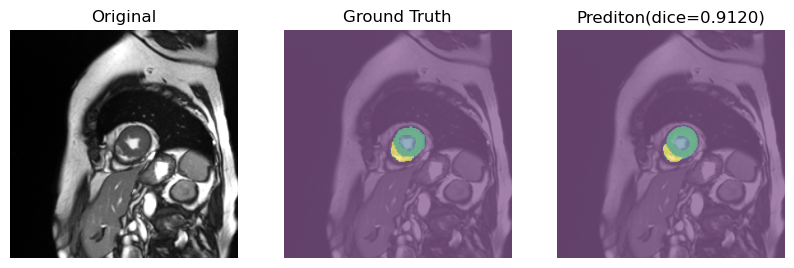

In [21]:
import matplotlib.pyplot as plt

plt.ion()


fig,axes=plt.subplots(1,3,figsize=(10,10))

axes[0].imshow(input_C[6,0,:,:],cmap="gray")
axes[0].set_title("Original")
axes[0].axis('off')

axes[1].imshow(input_C[6,0,:,:],cmap="gray",alpha=0.5)
axes[1].imshow(label_C[6,0,:,:],alpha=0.5)
axes[1].set_title("Ground Truth")
axes[1].axis('off')

axes[2].imshow(input_C[6,0,:,:],cmap="gray",alpha=0.5)
axes[2].imshow(label_pred_C[6],alpha=0.5)
axes[2].set_title("Prediton(dice=0.9120)")
axes[2].axis('off')
plt.show()
    
plt.ioff()

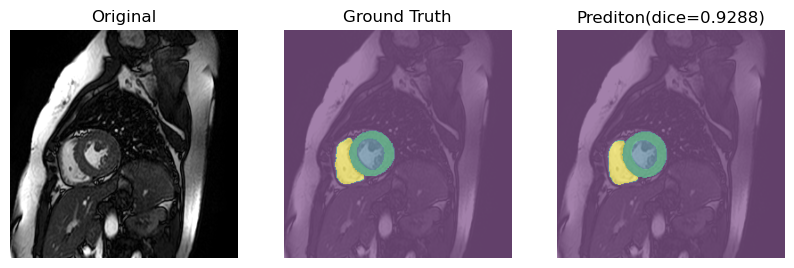

In [22]:
plt.ion()


fig,axes=plt.subplots(1,3,figsize=(10,10))

axes[0].imshow(input_D[6,0,:,:],cmap="gray")
axes[0].set_title("Original")
axes[0].axis('off')

axes[1].imshow(input_D[6,0,:,:],cmap="gray",alpha=0.5)
axes[1].imshow(label_D[6,0,:,:],alpha=0.5)
axes[1].set_title("Ground Truth")
axes[1].axis('off')

axes[2].imshow(input_D[6,0,:,:],cmap="gray",alpha=0.5)
axes[2].imshow(label_pred_D[6],alpha=0.5)
axes[2].set_title("Prediton(dice=0.9288)")
axes[2].axis('off')
plt.show()
    
plt.ioff()